In [ ]:
!bash ./drive/MyDrive/single-person-pose-estimation/dataset/get_data.sh

Streaming output truncated to the last 5000 lines.
 extracting: dataset/images/val2017/000000433980.jpg  
 extracting: dataset/images/val2017/000000228144.jpg  
 extracting: dataset/images/val2017/000000041872.jpg  
 extracting: dataset/images/val2017/000000117492.jpg  
 extracting: dataset/images/val2017/000000368900.jpg  
 extracting: dataset/images/val2017/000000376900.jpg  
 extracting: dataset/images/val2017/000000352491.jpg  
 extracting: dataset/images/val2017/000000330790.jpg  
 extracting: dataset/images/val2017/000000384850.jpg  
 extracting: dataset/images/val2017/000000032735.jpg  
 extracting: dataset/images/val2017/000000197004.jpg  
 extracting: dataset/images/val2017/000000526751.jpg  
 extracting: dataset/images/val2017/000000041488.jpg  
 extracting: dataset/images/val2017/000000153632.jpg  
 extracting: dataset/images/val2017/000000501523.jpg  
 extracting: dataset/images/val2017/000000405691.jpg  
 extracting: dataset/images/val2017/000000040757.jpg  
 extracting: d

In [1]:
import sys
sys.path.append('./drive/MyDrive/single-person-pose-estimation')

In [2]:
from configs import default_config as cfg
from coco_df import gen_trainval_df
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os

In [3]:
from gen_tfrecords import gen_TFRecords

In [4]:
train_df, valid_df = gen_trainval_df(cfg)

loading annotations into memory...
Done (t=20.29s)
creating index...
index created!
loading annotations into memory...
Done (t=0.55s)
creating index...
index created!
Only examples that are not crowd and num_keypoints > 0 are chosen !
Length of train df: 149813
Length of valid df: 6352


In [ ]:
train_df[:2000]

,coco_url,image_path,width,height,ann_id,is_crowd,bbox,num_keypoints,keypoints
image_id,,,,,,,,,
36,http://images.cocodataset.org/train2017/000000...,000000000036.jpg,481,640,453991,0,"[167.58, 162.89, 310.61, 465.19]",13,"[250, 244, 2, 265, 223, 2, 235, 235, 2, 309, 2..."
49,http://images.cocodataset.org/train2017/000000...,000000000049.jpg,381,500,198565,0,"[203.39, 260.43, 65.69, 73.04]",13,"[251, 276, 2, 253, 275, 2, 250, 274, 2, 259, 2..."
49,http://images.cocodataset.org/train2017/000000...,000000000049.jpg,381,500,254537,0,"[118.43, 261.32, 56.91, 62.93]",11,"[158, 270, 1, 160, 269, 2, 157, 269, 1, 167, 2..."
77,http://images.cocodataset.org/train2017/000000...,000000000077.jpg,500,375,471474,0,"[216.04, 56.31, 103.45, 118.93]",14,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 257, 73, 2, 267, 8..."
77,http://images.cocodataset.org/train2017/000000...,000000000077.jpg,500,375,502475,0,"[320.73, 53.73, 94.63, 97.28]",14,"[0, 0, 0, 0, 0, 0, 381, 69, 2, 0, 0, 0, 377, 6..."
...,...,...,...,...,...,...,...,...,...
8042,http://images.cocodataset.org/train2017/000000...,000000008042.jpg,640,360,443548,0,"[373.75, 50.02, 228.14, 301.76]",12,"[385, 135, 2, 399, 125, 2, 380, 119, 2, 441, 1..."
8042,http://images.cocodataset.org/train2017/000000...,000000008042.jpg,640,360,519734,0,"[537.26, 123.36, 71.16, 72.49]",10,"[566, 147, 2, 572, 144, 2, 564, 143, 2, 588, 1..."
8042,http://images.cocodataset.org/train2017/000000...,000000008042.jpg,640,360,1208480,0,"[252.4, 23.46, 145.62, 336.54]",13,"[326, 76, 2, 337, 66, 2, 316, 70, 2, 0, 0, 0, ..."


In [ ]:
print(list(train_df.columns))

['coco_url', 'image_path', 'width', 'height', 'ann_id', 'is_crowd', 'bbox', 'num_keypoints', 'keypoints']


In [ ]:
print(list(valid_df.columns))

['coco_url', 'image_path', 'width', 'height', 'ann_id', 'is_crowd', 'bbox', 'num_keypoints', 'keypoints']




---

Test cropping and padding

In [ ]:
im = tf.io.decode_jpeg(tf.io.read_file('dataset/images/train2017/000000008042.jpg'))

In [ ]:
print(tf.shape(im))

tf.Tensor([360 640   3], shape=(3,), dtype=int32)


In [ ]:
bbox =[603.15, 125.6, 36.85, 66.16]	
kps = [631,159,1,635,152,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,635,177,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

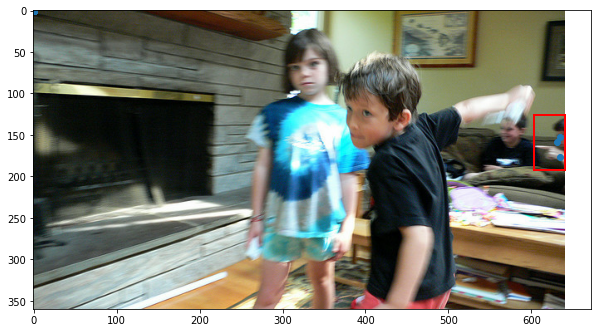

In [ ]:
fig, ax = plt.subplots(figsize = (10, 10))
# Display the image
ax.imshow(im)
# Create a Rectangle patch
rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=2, edgecolor='r', facecolor='none')
plt.scatter([kps[i] for i in range(len(kps)) if i%3 == 0], [kps[i] for i in range(len(kps)) if i%3 == 1])
# Add the patch to the Axes
ax.add_patch(rect)
plt.show()


In [ ]:
def transform_bbox_square(bbox, scale = 1):
  '''
  Make bbox into square with the side is the longer side of old bbox
  :param bbox: bbox (x, y, width, height)
  :param scale: scale the bbox
  '''
  x, y, w, h = bbox
  center_x = x + w/2
  center_y = y + h/2

  if w >= h:
    new_w = w
    new_h = w
  else:
    new_w = h
    new_h = h

  new_w *= scale
  new_h *= scale
  new_x = center_x - new_w/2
  new_y = center_y - new_h/2

  return new_x, new_y, new_w, new_h

In [ ]:
new_bbox = list(transform_bbox_square(bbox))

In [ ]:
print(new_bbox)

[588.4949999999999, 125.60000000000001, 66.16, 66.16]


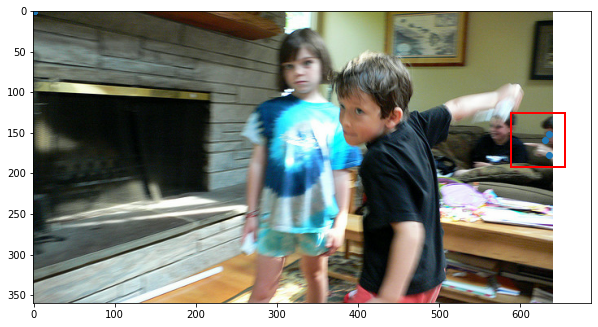

In [ ]:
fig, ax = plt.subplots(figsize = (10, 10))
# Display the image
ax.imshow(im)
# Create a Rectangle patch
rect = patches.Rectangle((new_bbox[0], new_bbox[1]), new_bbox[2], new_bbox[3], linewidth=2, edgecolor='r', facecolor='none')
plt.scatter([kps[i] for i in range(len(kps)) if i%3 == 0], [kps[i] for i in range(len(kps)) if i%3 == 1])
# Add the patch to the Axes
ax.add_patch(rect)
plt.show()

In [ ]:
new_x, new_y, new_w, new_h = new_bbox

In [ ]:
print(new_x, new_y, new_w, new_h)

588.4949999999999 125.60000000000001 66.16 66.16


In [ ]:
img_h, img_w, img_c = tf.shape(im)
print(img_w, img_h)

tf.Tensor(640, shape=(), dtype=int32) tf.Tensor(360, shape=(), dtype=int32)


In [ ]:
offset_x = 0
if new_x < 0:
  offset_x = - new_x
  new_x = 0

offset_y = 0
if new_y < 0:
  offset_y = - new_y
  new_y = 0

target_width = new_w
if new_x + new_w > int(img_w):
  new_w = int(img_w) - new_x

target_height = new_h
if new_y + new_h > int(img_h):
  new_h = int(img_h) - new_y

In [ ]:
new_w

51.50500000000011

In [ ]:
xcoords = [kps[i] - new_x for i in range(len(kps)) if i%3 == 0]
ycoords = [kps[i] - new_y for i in range(len(kps)) if i%3 == 1]

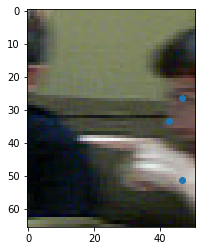

In [ ]:
new_img = tf.image.crop_to_bounding_box(im, int(new_y), int(new_x), int(new_h), int(new_w))
plt.scatter(xcoords, ycoords)
plt.imshow(new_img)

In [ ]:
tf.shape(new_img)

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([66, 51,  3], dtype=int32)>

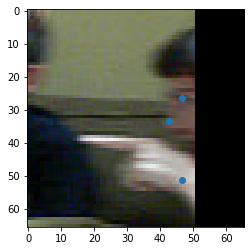

In [ ]:
new_img = tf.image.pad_to_bounding_box(new_img, int(offset_x), int(offset_y), int(target_height), int(target_width))
plt.scatter(xcoords, ycoords)
plt.imshow(new_img)

In [5]:
gen_TFRecords(valid_df, cfg, is_train = False)

TFRecords generated at dataset/tfrecords/valid


In [6]:
### For reading
def parse_tfrecord_fn(example):
    feature_description = {
        "ann_id": tf.io.FixedLenFeature([], tf.int64),
        "image_id": tf.io.FixedLenFeature([], tf.int64),
        "image": tf.io.FixedLenFeature([], tf.string),
        "image_path": tf.io.FixedLenFeature([], tf.string),
        "width": tf.io.FixedLenFeature([], tf.int64),
        "height": tf.io.FixedLenFeature([], tf.int64),
        "keypoints/x": tf.io.VarLenFeature(tf.float32),
        "keypoints/y": tf.io.VarLenFeature(tf.float32),
        "keypoints/vis": tf.io.VarLenFeature(tf.int64),
        "keypoints/num": tf.io.FixedLenFeature([], tf.int64)
    }
    
    example = tf.io.parse_single_example(example, feature_description)
    example["image"] = tf.image.decode_image(example["image"], channels = 3, dtype = tf.float32, expand_animations =False)
    example["keypoints/x"] = tf.sparse.to_dense(example["keypoints/x"])
    example["keypoints/y"] = tf.sparse.to_dense(example["keypoints/y"])
    example["keypoints/vis"] = tf.sparse.to_dense(example["keypoints/vis"])
    return example


In [7]:
### example
def gen_examples_from_tfrecord(filepath, example_num):
  raw_dataset = tf.data.TFRecordDataset(filepath)
  parsed_dataset = raw_dataset.map(parse_tfrecord_fn)
  for example in parsed_dataset.take(example_num):
      for key in example.keys():
          if key != "image":
              print(f"{key}: {example[key]}")

      xcoords = example["keypoints/x"].numpy()
      ycoords = example["keypoints/y"].numpy()
      image = example["image"]
      h, w, c = image.shape
      print(f"Image shape: {image.shape}")
      plt.figure(figsize=(7, 7))
  
      plt.imshow(image)
      plt.scatter(xcoords  , ycoords  , marker = "o") # for heatmap size
      plt.show()  

In [ ]:
# before fixed kp == 0
gen_examples_from_tfrecord('dataset/tfrecords/valid/file_valid_00-1024.tfrec',50)

Output hidden; open in https://colab.research.google.com to view.

In [8]:
# after fixing 0 and kps (v = 1) out of box
gen_examples_from_tfrecord('dataset/tfrecords/valid/file_valid_00-2048.tfrec', 50)



---



---
WEIRD!!!


In [ ]:
!python './drive/MyDrive/single-person-pose-estimation/gen_tfrecords.py'

loading annotations into memory...
Done (t=20.53s)
creating index...
index created!
loading annotations into memory...
Done (t=0.29s)
creating index...
index created!
Only examples that are not crowd and num_keypoints > 0 are chosen !
Length of train df: 149813
Length of valid df: 6352
2022-03-17 09:06:10.119266: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
y
Traceback (most recent call last):
  File "./drive/MyDrive/single-person-pose-estimation/gen_tfrecords.py", line 168, in <module>
  File "./drive/MyDrive/single-person-pose-estimation/gen_tfrecords.py", line 158, in gen_TFRecords
    image = tf.io.decode_jpeg(tf.io.read_file(image_path))
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gen_image_ops.py", line 1175, in decode_jpeg
    name=name, ctx=_ctx)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gen_image_ops.py", line 1245, in decode_jpeg_eager_f



---



---

Failed cases for padding


---



---



In [ ]:
valid_df[:5]

,coco_url,image_path,width,height,ann_id,is_crowd,bbox,num_keypoints,keypoints
image_id,,,,,,,,,
139,http://images.cocodataset.org/val2017/00000000...,000000000139.jpg,640,426,230831,0,"[412.8, 157.61, 53.05, 138.01]",15,"[427, 170, 1, 429, 169, 2, 0, 0, 0, 434, 168, ..."
785,http://images.cocodataset.org/val2017/00000000...,000000000785.jpg,640,425,442619,0,"[280.79, 44.73, 218.7, 346.68]",17,"[367, 81, 2, 374, 73, 2, 360, 75, 2, 386, 78, ..."
872,http://images.cocodataset.org/val2017/00000000...,000000000872.jpg,621,640,559508,0,"[145.26, 100.67, 291.95, 457.35]",12,"[367, 138, 2, 0, 0, 0, 360, 134, 2, 0, 0, 0, 3..."
872,http://images.cocodataset.org/val2017/00000000...,000000000872.jpg,621,640,560228,0,"[163.73, 126.42, 265.69, 480.4]",15,"[211, 187, 1, 215, 179, 2, 0, 0, 0, 241, 175, ..."
885,http://images.cocodataset.org/val2017/00000000...,000000000885.jpg,640,427,439117,0,"[277.31, 189.99, 140.09, 208.22]",16,"[374, 216, 2, 379, 214, 2, 370, 212, 2, 0, 0, ..."


In [ ]:
im = tf.io.decode_jpeg(tf.io.read_file('dataset/images/val2017/000000000872.jpg'))
im.shape

TensorShape([640, 621, 3])

In [ ]:
kps =[211,187,1,215,179,2,0,0,0,241,175,2,0,0,0,280,228,2,236,232,2,326,300,2,245,292,2,289,358,2,195,331,2,297,354,2,240,355,1,294,480,2,227,470,2,376,410,2,245,570,2]
bbox = [	163.73,126.42,265.69,480.4]

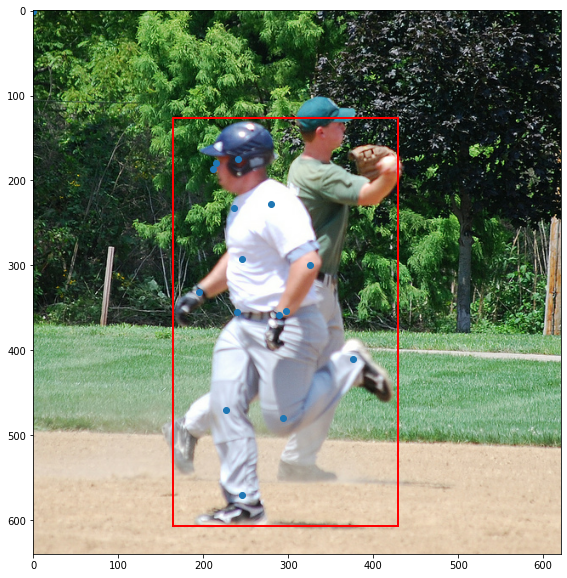

In [ ]:
fig, ax = plt.subplots(figsize = (10, 10))
# Display the image
ax.imshow(im)
# Create a Rectangle patch
rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=2, edgecolor='r', facecolor='none')
plt.scatter([kps[i] for i in range(len(kps)) if i%3 == 0], [kps[i] for i in range(len(kps)) if i%3 == 1])
# Add the patch to the Axes
ax.add_patch(rect)
plt.show()

In [ ]:
new_bbox = list(transform_bbox_square(bbox, 1.25))

In [ ]:
new_bbox

[-3.6750000000000114, 66.37, 600.5, 600.5]

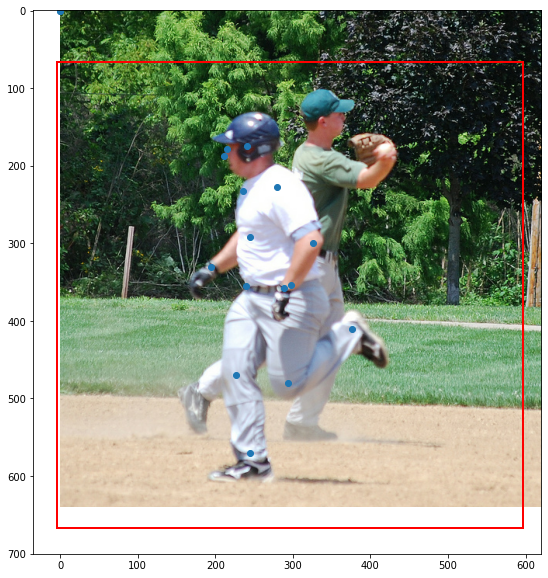

In [ ]:
fig, ax = plt.subplots(figsize = (10, 10))
# Display the image
ax.imshow(im)
# Create a Rectangle patch
rect = patches.Rectangle((new_bbox[0], new_bbox[1]), new_bbox[2], new_bbox[3], linewidth=2, edgecolor='r', facecolor='none')
plt.scatter([kps[i] for i in range(len(kps)) if i%3 == 0], [kps[i] for i in range(len(kps)) if i%3 == 1])
# Add the patch to the Axes
ax.add_patch(rect)
plt.show()



---



---

Test occluded joints and invisible joint


---



---

